In [1]:
#from __future__ import division # uncomment this if using Python 2.7
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage import draw as drw
from skimage import data, color, exposure, img_as_float, img_as_ubyte, filters, morphology, io
import math
import random
import statistics
from google.colab import drive
import cv2
from scipy import ndimage
%matplotlib inline

# Necessary Functions:
pre processing the image: float function, reducing channels to gray only, adding salt and pepper noise

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


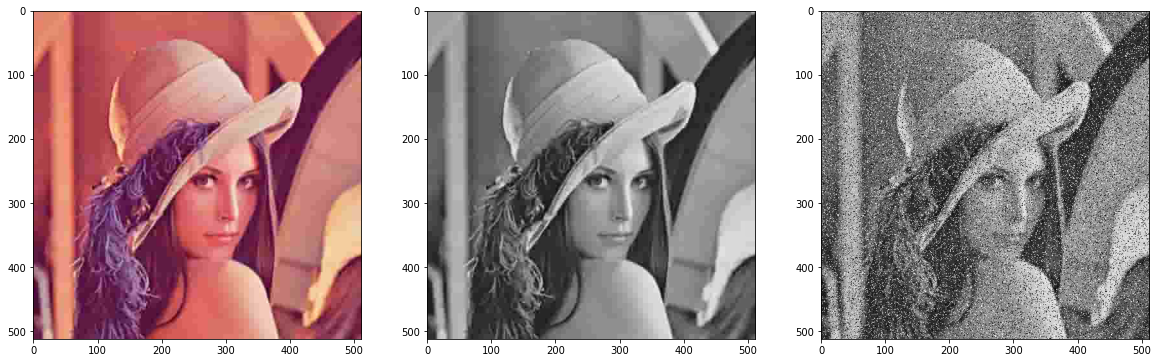

In [3]:
def my_uint2float(img):
    return ((1/255.)*img) 

def my_rgb2gray(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    #Y = 0.2125*R+0.7154*G+0.0721*B
    Y = 0.3*R + 0.59*G + 0.11*B 
#I tried another formula. The Green always get the highest weight, followed by Red and then Blue#
    Y=my_uint2float(Y)
    return Y
def add_sp(img,perc):
    """ add salt and pepper noise to the input image """
    n , m= img.shape
    noisenum = math.floor(n*m*perc/100)
    for i in range (0,noisenum):
        nn = np.random.randint(n)
        mm = np.random.randint(m)
        img[nn,mm] = random.choice([0,1])
        #img[nn,mm] = np.random.randi(0,255)
    return img 
fig=plt.figure(figsize=[20,15])
a1=fig.add_subplot(131)
a2=fig.add_subplot(132)
a3=fig.add_subplot(133)

img=io.imread('/content/drive/MyDrive/Colab Notebooks/lena5.jpeg')
a1.imshow(img)

gimg=my_rgb2gray(img)
a2.imshow(gimg,cmap='gray')

perc=20
noisyimg=add_sp(gimg,perc)
a3.imshow(noisyimg,cmap='gray')


In [4]:
def im2col(I,B,winsize):
    x=np.pad(I,(winsize,winsize),'symmetric')
    rowp,colp=np.shape(x)
    idx=0
    kernel=(2*winsize+1)**2
    for j in range(winsize,colp-winsize):
        for i in range(winsize,rowp-winsize): #for each pixel
            N=x[i-winsize:i+winsize+1,j-winsize:j+winsize+1]
            B[0:kernel,idx]=N.ravel()
            idx=idx+1
    return B
#k=np.arange(0,12)
#I=k.reshape([3,4])
#row,col=np.shape(I)
#winsize=1
#res=im2col(I,winsize)
#print(res)

In [5]:
def col2im(I): #reconstruct an image from the padded im2col
    temp=I[kernel//2,:]
    for k in range(col):
        rec[:,k]=temp[k*row:k*row+row]
    return rec

In [7]:
def applythreshold(noisyimg,c0,c1,c2,c3):
    print("sizes", noisyimg.shape,c0.shape,c1.shape,c2.shape,c3.shape)
    F=np.zeros(np.shape(noisyimg))
    F0=np.zeros(np.shape(noisyimg))
    F1=np.zeros(np.shape(noisyimg))
    F2=np.zeros(np.shape(noisyimg))
    F3=np.zeros(np.shape(noisyimg))
    for i in range(0,len(c0)):
        rr=i//(len(noisyimg))
        cc=np.mod(i,(len(noisyimg)))
        #print("rr,cc,i,c0[i]",rr,cc,i,c0[i])
        F0[rr,cc]=c0[i]
        F1[rr,cc]=c1[i]
        F2[rr,cc]=c2[i]
        F3[rr,cc]=c3[i]
    print("F0= ", F0)
    print("F1= ",F1)
    print("F2=", F2)
    print("F3=",F3)
    F=(F0+F1+F2+F3)
    F=np.where(F>0,1,0)
    return F


u=np.arange(1,13)
u = u.reshape([3,4])

d0=np.arange(0,np.size(u))
d1=np.arange(0+10,np.size(u)+10)
d2=np.arange(0+20,np.size(u)+20)
d3=np.arange(0+30,np.size(u)+30)
t0=3
t1=14
t2=26
t3=37
c0=d0>t0
print('c0= ',c0)
c1=d1>t1
print('c1= ',c1)
c2=d2>t2
print('c2= ',c2)
c3=d3>t3
print(np.shape(c0))
print(np.shape(u))
F=applythreshold(u,c0,c1,c2,c3)
print(F)

In [8]:
def acwmf(I):
    delta=[40,25,20,5] #threshold parameters
    row,col=np.shape(I)
    winsize=1
    kernel=(2*winsize+1)**2
    B=np.zeros((kernel+6,row*col))
    B=im2col(I,B,winsize)
    m = ndimage.median_filter(I, size=3) #filter outputs with w=0 for MAD , d0
    d=np.abs(I-m) #difference of noisyimg and median image pixelwise = Y0
    d0=d.ravel('F') #column wise ravel
    B[9,:]=I.ravel('F')
    B[10,:]=I.ravel('F') #twice because of 2k 2(1)=2
    Y1=np.median(B,0) 
    d1=np.abs(I.ravel('F')-Y1) #difference between each point and its neighors median [pixels in a row]
    
    B[11,:]=I.ravel('F')
    B[12,:]=I.ravel('F') #twice because of 2k 2(2)=2
    Y1=np.median(B,0) #########update Y1
    d2=np.abs(I.ravel('F')-Y1)
    
    B[13,:]=I.ravel('F')
    B[14,:]=I.ravel('F') #twice because of 2k 2(3)=2
    Y1=np.median(B,0)
    d3=np.abs(I.ravel('F')-Y1)
    
    Bx=np.zeros((kernel+6,row*col))
    Bx=im2col(I,Bx,winsize)
    
    for l in range(0,9):
        B[l,:]=np.abs(Bx[l,:]-m.ravel('F'))
    
    MAD=np.median(B,0) #########update
    #compute threshold values:
    s=0.1
    t0=(MAD*s)+delta[0]
    t1=(MAD*s)+delta[1]
    t2=(MAD*s)+delta[2]
    t3=(MAD*s)+delta[3]
    
    t=I.ravel('F')
    I2=t.reshape([len(t),1])
    
    c0=d0>t0
    c1=d1>t1
    c2=d2>t2
    c3=d3>t3
    print(np.shape(c0))
    noisematrix=applythreshold(noisyimg,c0,c1,c2,c3)
    
    #replace noisy pixels:
    I2[noisematrix]=m[noisematrix]
    y=col2im(I2)
    print("dddd", noisematrix.shape)
    return y,noisematrix    

In [ ]:
a,b=np.shape(noisyimg)
rmax=3
X=noisyimg
data=[]
for r in range (0,rmax+1):
    Y, M[:,:,r+1]=acwmf(X)
    N=sum(M,3)
    Yhat=X
    for i in range(2,a):
        for b in range(2,b):
            if N(N[i,j]!=0):
                if np.mod(i+j,2)==0:
                    data.append(X[i,j])
                    if N[i,j-1]==0:
                        data.append(X[i,j-1])
                        data.append(X[i,j-1])
                    if N[i,j+1]==0:
                        data.append(X[i,j+1])
                        data.append(X[i,j+1])
                    if N[i-1,j]==0:
                        data.append(X[i-1,j])
                        data.append(X[i-1,j])
                    if N[i+1,j]==0:
                        data.append(X[i+1,j])
                        data.append(X[i+1,j])
                    if N[i,j-1]!=0:
                        data.append(Y[i,j-1])
                    if N[i,j+1]==0:
                        data.append(Y[i,j+1])
                    if N[i-1,j]==0:
                        data.append(Y[i-1,j])
                    if N[i+1,j]==0:
                        data.append(Y[i+1,j])
                if np.mod(i+j,2)!=0:
                    data.append(X[i,j])
                    if N[i,j-1]==0:
                        data.append(X[i,j-1])
                        data.append(X[i,j-1])
                    if N[i,j+1]==0:
                        data.append(X[i,j+1])
                        data.append(X[i,j+1])
                    if N[i-1,j]==0:
                        data.append(X[i-1,j])
                        data.append(X[i-1,j])
                    if N[i+1,j]==0:
                        data.append(X[i+1,j])
                        data.append(X[i+1,j])
                    if N[i,j-1]!=0:
                        data.append(Yhat[i,j-1])
                    if N[i,j+1]==0:
                        data.append(Yhat[i,j+1])
                    if N[i-1,j]==0:
                        data.append(Yhat[i-1,j])
                    if N[i+1,j]==0:
                        data.append(Yhat[i+1,j])
                Yhat[i,j]=statistics.median(data)
                data=[]
    X=Yhat